In [2]:
from random import random
from random import seed
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [3]:
# (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# normalization
# x_train = X_train.reshape(60000,784)/255
# x_test = X_test.reshape(10000,784)/255
# label_train = to_categorical(Y_train)
# label_test = to_categorical(Y_test)
# print(label_train[0,:].shape)

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
x_train = X_train.reshape(60000,28, 28,1)/255
x_test = X_test.reshape(10000, 28, 28,1)/255
x_train = x_train.reshape(60000,-1)
x_test = x_test.reshape(10000,-1)
y_train = pd.get_dummies(Y_train).to_numpy()
y_test = pd.get_dummies(Y_test).to_numpy()
print('Train features',x_train.shape,'train labels',y_train.shape)
print('Test features',x_test.shape,'test labels',y_test.shape)

Train features (60000, 784) train labels (60000, 10)
Test features (10000, 784) test labels (10000, 10)


In [4]:
def initialize_network(n_inputs, n_hidden, n_outputs):
    layer1 = np.random.randn(n_hidden,n_inputs+1)/10
    layer2 = np.random.randn(n_outputs,n_hidden+1)/10
    return layer1, layer2

def weighted_sum(weights, inputs):
    inputs = np.append(inputs,[1])
    inputs = inputs.reshape((len(inputs),1))
    outputs = weights.dot(inputs)
    return outputs

def tanh(activation):
    return (np.exp(activation) - np.exp(-activation))/(np.exp(activation) + np.exp(-activation))

def tanh_derivative(output): #原本的output 要在乘上sigmoid 在乘上
    return 1 - tanh(output)**2

def MSE(label, train):
    error = label - train
    error = np.square(error)
    error = np.sum(error)
    return 0.5*error

def MSE2(y,y_hat):
    err_avg = np.sum((y_hat-y)**2,axis=1)
    return sum(err_avg)/y_hat.shape[0]

def MSE_derivative(label, train):
    return label - train

def forward_propagate(layer1, layer2, inputs):
    output0 = weighted_sum(layer1, inputs)      # layer1 還沒經過 activate function
    output1 = tanh(output0)                  # layer1 經過 activate function
    output4 = weighted_sum(layer2, output1)     # layer2 還沒經過 activate function
    output2 = tanh(output4)                  # layer2 經過 activate function
    return output1, output2, output0, output4
# ------------------------------------------- 批量輸出 ------------------------------------ # 
def net_output(layer1, layer2, inputs):
    inputs = np.concatenate((inputs,np.ones(inputs.shape[0]).reshape(-1,1)), axis=1) 
    output1 = tanh(layer1.dot(inputs.T))   
    output1 = np.concatenate((output1,np.ones(output1.shape[1]).reshape(1,-1)),axis=0)
    output2 = tanh(layer2.dot(output1))                  
    return output2

def backward_propagate(layer1, layer2, output1, output2, output0, output4, ln_rate, inputs, label):
    #delta2
    error2 = MSE_derivative(label, output2)*tanh_derivative(output4)
    error2 = error2.reshape((len(error2),1))
    output1 = np.append(output1,[1])
    output1 = output1.reshape((1,len(output1)))
    delta2 = ln_rate*error2.dot(output1)
    #delta1
    error1 = error2.reshape((1,len(output2))).dot(layer2)
    error1 = np.delete(error1, len(error1)-1)
    error1 = error1.reshape((len(error1),1))
    error1 = error1*tanh_derivative(output0)
    inputs = np.append(inputs,[1])
    inputs = inputs.reshape((1,len(inputs)))
    delta1 = ln_rate*error1.dot(inputs)
    #Update weights
    layer1 = layer1 + delta1
    layer2 = layer2 + delta2
    return layer1, layer2

def mc_acc(yhat,y):
    y_hat = np.argmax(yhat,axis=1)
    yy = np.argmax(y,axis=1)
    return np.sum(np.equal(y_hat,yy))/len(yy)
    
def acc_multiclass(ee,epochs,layer1, layer2,x_train,x_test,y_train,y_test):
    y_te = net_output(layer1, layer2,x_test)
    tel = MSE2(y_te.T,y_test)
    
    y_tr = net_output(layer1, layer2,x_train)
    tl = MSE2(y_tr.T,y_train)
    
    ta = mc_acc(y_tr.T,y_train)
    tea = mc_acc(y_te.T,y_test)   
    
    print("Epoch",ee+1,"/",epochs,"- loss: %.4f" %tl,"- accuracy: %.4f" %ta,
        "- test_loss: %.4f" %tel,"- test_accuracy: %.4f" %tea)            
    return tl, ta, tel, tea

def train_network(layer1, layer2, x_train, y_train, x_test, y_test, ln_rate, epoch, batch_size):
    loss = []
    accuracy = []
    test_loss = []
    test_accuracy = []
    for ee in range(epoch):
        for index,x_dd in enumerate(x_train):
            output1, output2, output0, output4 = forward_propagate(layer1, layer2, x_dd)
            layer1, layer2 = backward_propagate( layer1, layer2, output1, output2, output0, output4, ln_rate, x_dd ,label=y_train[index].reshape(-1,1))     
            
        tl, ta, tel, tea = acc_multiclass(ee,epoch,layer1, layer2,x_train,x_test,y_train,y_test)
        loss.append(tl)
        accuracy.append(ta)
        test_loss.append(tel)
        test_accuracy.append(tea)
        
    return layer1, layer2, loss, accuracy, test_loss, test_accuracy

Epoch 1 / 40 - loss: 0.5933 - accuracy: 0.8674 - test_loss: 0.5892 - test_accuracy: 0.8759
Epoch 2 / 40 - loss: 0.4821 - accuracy: 0.8960 - test_loss: 0.4765 - test_accuracy: 0.9018
Epoch 3 / 40 - loss: 0.4276 - accuracy: 0.9117 - test_loss: 0.4283 - test_accuracy: 0.9138
Epoch 4 / 40 - loss: 0.3264 - accuracy: 0.9186 - test_loss: 0.3268 - test_accuracy: 0.9177
Epoch 5 / 40 - loss: 0.2376 - accuracy: 0.9288 - test_loss: 0.2395 - test_accuracy: 0.9260
Epoch 6 / 40 - loss: 0.2008 - accuracy: 0.9376 - test_loss: 0.2027 - test_accuracy: 0.9359
Epoch 7 / 40 - loss: 0.1811 - accuracy: 0.9427 - test_loss: 0.1841 - test_accuracy: 0.9404
Epoch 8 / 40 - loss: 0.1566 - accuracy: 0.9440 - test_loss: 0.1621 - test_accuracy: 0.9405
Epoch 9 / 40 - loss: 0.1512 - accuracy: 0.9412 - test_loss: 0.1586 - test_accuracy: 0.9364
Epoch 10 / 40 - loss: 0.1532 - accuracy: 0.9416 - test_loss: 0.1610 - test_accuracy: 0.9377
Epoch 11 / 40 - loss: 0.1865 - accuracy: 0.9354 - test_loss: 0.1955 - test_accuracy: 0.92

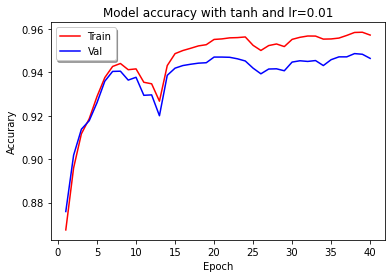

In [6]:
# Model accuracy with tanh and lr=0.01
layer1, layer2 = initialize_network(784,128,10)
ln_rate = 0.01
epoch = 40
batch_size = 1
layer1, layer2, loss, accuracy, test_loss, test_accuracy = train_network(layer1, layer2, x_train, y_train, x_test, y_test, ln_rate, epoch, batch_size)

x = []
for i in range(epoch):
    x.append(i+1)

plt.title("Model accuracy with tanh and lr=0.01") 
plt.xlabel("Epoch") 
plt.ylabel("Accurary")
plt.plot(x,accuracy,'-',color='red',label='Train')
plt.plot(x,test_accuracy,'-',color='blue',label='Val')
plt.legend(loc='upper left', shadow=True)

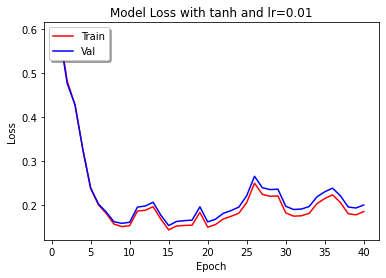

In [7]:
plt.title("Model Loss with tanh and lr=0.01") 
plt.xlabel("Epoch") 
plt.ylabel("Loss")
plt.plot(x,loss,'-',color='red',label='Train')
plt.plot(x,test_loss,'-',color='blue',label='Val')
plt.legend(loc='upper left', shadow=True)

Epoch 1 / 40 - loss: 8.9536 - accuracy: 0.1672 - test_loss: 8.9534 - test_accuracy: 0.1672
Epoch 2 / 40 - loss: 9.3304 - accuracy: 0.1358 - test_loss: 9.3224 - test_accuracy: 0.1354
Epoch 3 / 40 - loss: 9.3142 - accuracy: 0.0995 - test_loss: 9.3123 - test_accuracy: 0.0986
Epoch 4 / 40 - loss: 9.3610 - accuracy: 0.0988 - test_loss: 9.3566 - test_accuracy: 0.0981
Epoch 5 / 40 - loss: 9.3594 - accuracy: 0.0989 - test_loss: 9.3547 - test_accuracy: 0.0983
Epoch 6 / 40 - loss: 9.3592 - accuracy: 0.0989 - test_loss: 9.3549 - test_accuracy: 0.0982
Epoch 7 / 40 - loss: 9.3571 - accuracy: 0.0987 - test_loss: 9.3521 - test_accuracy: 0.0980
Epoch 8 / 40 - loss: 9.3614 - accuracy: 0.0987 - test_loss: 9.3568 - test_accuracy: 0.0980
Epoch 9 / 40 - loss: 9.3538 - accuracy: 0.0987 - test_loss: 9.3496 - test_accuracy: 0.0980
Epoch 10 / 40 - loss: 9.3503 - accuracy: 0.0987 - test_loss: 9.3456 - test_accuracy: 0.0980
Epoch 11 / 40 - loss: 9.3609 - accuracy: 0.0987 - test_loss: 9.3564 - test_accuracy: 0.09

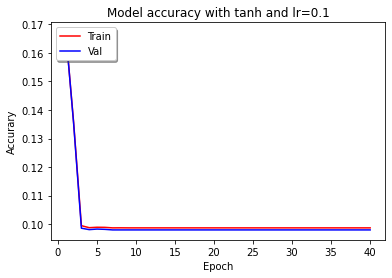

In [8]:
# Model accuracy with tanh and lr=0.1
layer1, layer2 = initialize_network(784,128,10)
ln_rate = 0.1
epoch = 40
batch_size = 1
layer1, layer2, loss, accuracy, test_loss, test_accuracy = train_network(layer1, layer2, x_train, y_train, x_test, y_test, ln_rate, epoch, batch_size)

x = []
for i in range(epoch):
    x.append(i+1)
plt.title("Model accuracy with tanh and lr=0.1") 
plt.xlabel("Epoch") 
plt.ylabel("Accurary")
plt.plot(x,accuracy,'-',color='red',label='Train')
plt.plot(x,test_accuracy,'-',color='blue',label='Val')
plt.legend(loc='upper left', shadow=True)

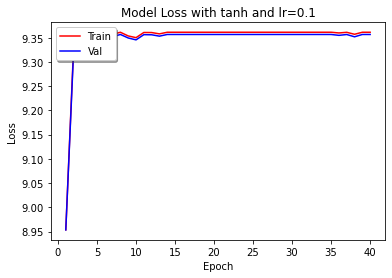

In [9]:
plt.title("Model Loss with tanh and lr=0.1") 
plt.xlabel("Epoch") 
plt.ylabel("Loss")
plt.plot(x,loss,'-',color='red',label='Train')
plt.plot(x,test_loss,'-',color='blue',label='Val')
plt.legend(loc='upper left', shadow=True)